# 1. Load Config

In [1]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

from model.worldgpt import load_worldgpt_model
from model.preprocessor import PreProcessor
from config import load_config

/home2/hhz/miniconda3/envs/worldgpt/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home2/hhz/miniconda3/envs/worldgpt/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
_args = {'mode': 'test', 'cfg_path': 'config/test_decode.yaml'}
args = load_config(_args)
args.update(_args)

if 'dtype' not in args:
    args['dtype'] = torch.float16
elif args['dtype'] == 'fp16':
    args['dtype'] = torch.float16
elif args['dtype'] == 'bf16':
    args['dtype'] = torch.bfloat16
else:
    args['dtype'] = torch.float

[!] load base configuration: config/base.yaml
[!] load configuration from config/decode/decode_eval.yaml


# 2. Load Models

Load WorldGPT

In [3]:
model = load_worldgpt_model(**args)
model = model.eval().to(device='cuda', dtype=args['dtype'])

args max_length 128
Initializing language decoder from /home/user/data/weights/nextgpt/vicuna_ckpt ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]


Adding LoRa module ...
trainable params: 33,554,432 || all params: 6,771,978,240 || trainable%: 0.49548936530546206
Language decoder initialized.
Initializing tokenizer from /home/user/data/weights/nextgpt/vicuna_ckpt ...
Adding [IMG0] token to vocabulary.
Before adding new token, tokenizer("[IMG0]") = {'input_ids': [518, 7833, 29954, 29900, 29962], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG0]") = {'input_ids': [32002], 'attention_mask': [1]}
Adding [IMG1] token to vocabulary.
Before adding new token, tokenizer("[IMG1]") = {'input_ids': [518, 7833, 29954, 29896, 29962], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG1]") = {'input_ids': [32003], 'attention_mask': [1]}
Adding [IMG2] token to vocabulary.
Before adding new token, tokenizer("[IMG2]") = {'input_ids': [518, 7833, 29954, 29906, 29962], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG2]") = {'input_ids': [32004], 'attention_mask': [1]

Load LanguageBind encoder

In [4]:
preprocessor = PreProcessor(args)
preprocessor.to_(device='cuda', dtype=args['dtype'])

Loading LanguageBind model...


Load image decoder

In [5]:
decoder_pipe = StableDiffusionPipeline.from_pretrained(args['decoder_path']['image'], torch_dtype=args['dtype']).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [09:02<00:00, 77.47s/it] 


# 3. Run Inference

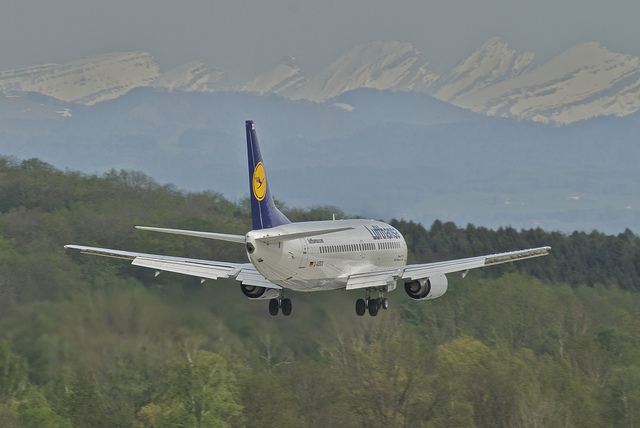

The plane is landing


In [58]:
image_path = 'demo/decode/plane.jpg'
action = 'The plane is landing'
image = Image.open(image_path)
image.show()
print(action)
inputs, _ = preprocessor({'image': [image], 'text': [action]})
target_modality = ['image']

100%|██████████| 30/30 [00:01<00:00, 16.47it/s]


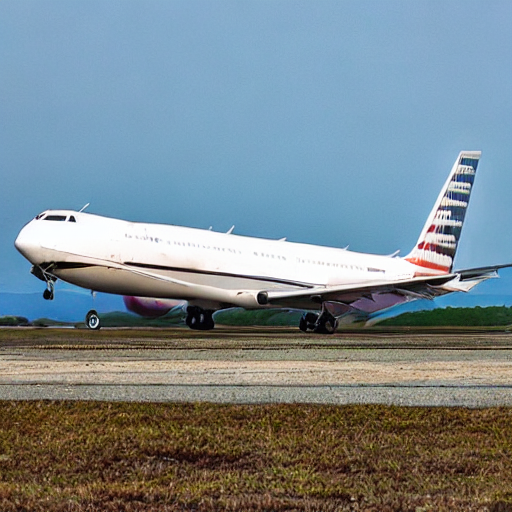

In [62]:
trunc_len = 16

with torch.no_grad():
    pred = model.generate(inputs, target_modality, enable_decode=True,
                          max_tgt_length=args['max_tgt_length'], top_p=args['top_p'],
                          temperature=args['temperature'])['image']
trunc_pred = pred[:, :trunc_len, :]
action_tokens = decoder_pipe.tokenizer(inputs['text'], padding=True, return_tensors='pt', truncation=True).to('cuda')
action_embeds = decoder_pipe.text_encoder(**action_tokens).last_hidden_state
mask = (action_tokens['attention_mask'] == 0).unsqueeze(-1).repeat(1, 1, action_embeds.shape[-1])
action_embeds.masked_fill_(mask, 0)
decoder_inputs = torch.cat([action_embeds[:, :1, :], trunc_pred, action_embeds[:, 1:, :]], dim=1)[:, :77, :]
generator = torch.Generator(device='cuda')
generator.manual_seed(8563)
with torch.no_grad():
    decoder_outputs = decoder_pipe(prompt_embeds=decoder_inputs, num_inference_steps=30, generator=generator).images
decoder_outputs[0].show()